In [398]:

from datetime import datetime
import MetaTrader5 as mt5
import numpy as np

mt5.initialize()

eurusd_rates = mt5.copy_rates_range("XAUAUD", mt5.TIMEFRAME_H1, datetime(2020,4,1,13), datetime(2020,4,25,13))

mt5.shutdown()

True

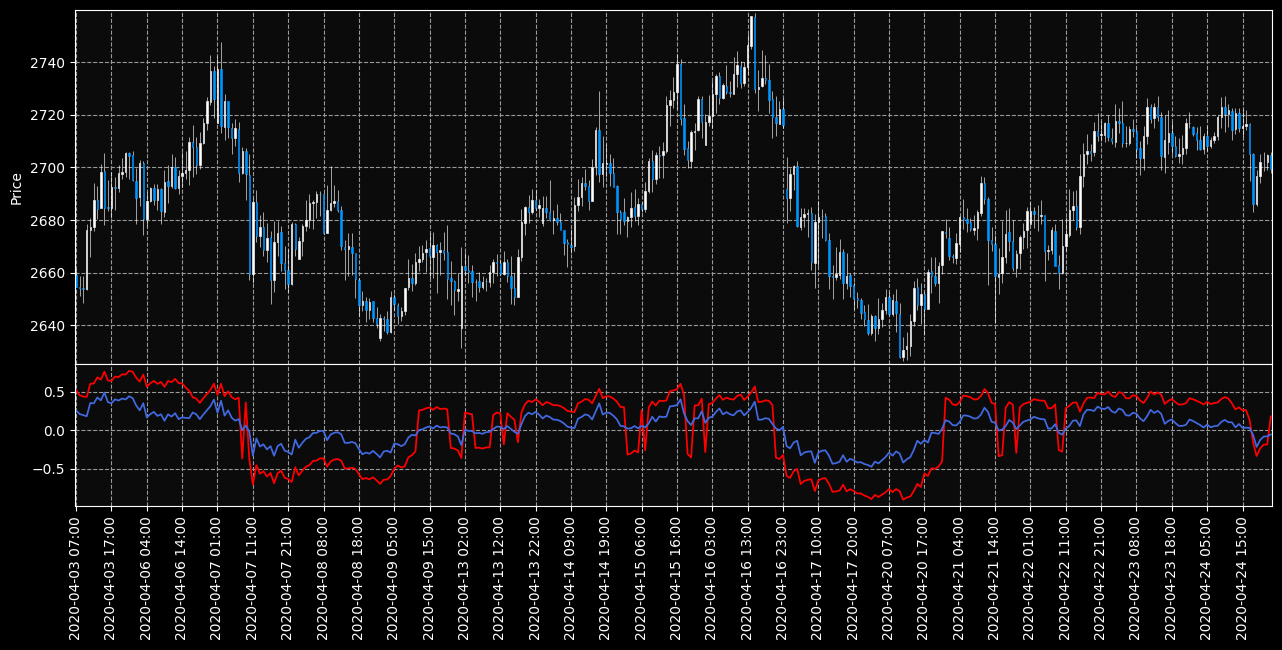

In [400]:
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf

import pandas as pd


def _return(d: pd.Series):
    return d.iloc[-1]/d.iloc[0]-1


def _slope(d: pd.Series):
    sl = (d.iloc[-1] - d.iloc[:d.size-1]) / np.arange(d.size+100, 101, -1)
    return sl.iloc[np.argmax(abs(sl))]


def _slopeM(d: pd.Series):
    sl = (d.iloc[-1] - d.iloc[:d.size-1]) / np.arange(d.size+100, 101, -1)
    return sl.mean()


def _slopeV(d: pd.Series):
    sl = (d.iloc[-1] - d.iloc[:d.size-1]) / np.arange(d.size, 1, -1)
    return sl.std()


df = pd.DataFrame(eurusd_rates).loc[:, [
    'time', 'open', 'high', 'low', 'close', 'tick_volume']]
df = df.rename(columns={'time': 'Time', 'high': 'High', 'low': 'Low',
                        'close': 'Close', 'tick_volume': 'Volume', 'open': 'Open'})

df['Time'] = pd.to_datetime(df['Time'], unit='s')
df = df.set_index('Time')


df['Return'] = df['Open'].rolling(24).apply(_return)
df['Slope'] = df['Open'].rolling(48).apply(_slope)
df['SlopeM'] = df['Open'].rolling(48).apply(_slopeM)
df['SlopeV'] = df['Open'].rolling(48).apply(_slopeV)
df['VarH'] = (df['High'] - df['Low'] +
              abs(df['Open'] - df['Close']) * 2).rolling(48).std()
df['VarP'] = df['Open'].rolling(48).std()


df = df[48:]


# df['Sell'] = [df['Open'].iloc[i] if x > 1 and df['SlopeM'].iloc[i] > 0.8 else np.nan for i, x in enumerate(df['Slope'])]
# df['Buy'] = [df['Open'].iloc[i] if x < -1 and df['SlopeM'].iloc[i] < -0.8 else np.nan for i, x in enumerate(df['Slope'])]


# df['Sell'] = [df['Open'].iloc[i] if x > 1 else np.nan for i, x in enumerate(df['Slope'])]
# df['Buy'] = [df['Open'].iloc[i] if x < -1 else np.nan for i, x in enumerate(df['Slope'])]


apds = [
    # mpf.make_addplot(tcdf),
    # mpf.make_addplot(low_signal, type='scatter', markersize=200, marker='^'),
    # mpf.make_addplot(high_signal, type='scatter', markersize=200, marker='v'),
    # mpf.make_addplot(df['Return'], panel=1, color='royalblue'),
    mpf.make_addplot(df['Slope'], panel=1, color='red', secondary_y=False),
    mpf.make_addplot(df['SlopeM'], panel=1, color='royalblue', secondary_y=False),

    # mpf.make_addplot(df['Sell'], type='scatter ', markersize=100, marker='v', color='red'),
    # mpf.make_addplot(df['Buy'], type='scatter', markersize=100, marker='^', color='blue'),
    # mpf.make_addplot(df['SlopeX'], panel=1, color='royalblue'),
    # mpf.make_addplot(df['VarH'], panel=1, color='yellow', secondary_y=True),
    # mpf.make_addplot(df['VarP'], panel=1, color='lime', secondary_y=True),
]
fig, axes = mpf.plot(df, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=50, axis='x')
plt.show()
